# Text to Speech

When solving some problem with deep learning in practice, you search the Web for the latest paper that solves that task, and take its implementation from GitHub. However, often there is no code, so being able to **reimplement a paper** is a vital skill. You will likely have to do it in your course project, and we are going to practice it in this assignment.

Let's focus on the task of text-to-speech (**TTS**) synthesis.

![](https://user-images.githubusercontent.com/9570420/81783573-392ed600-9504-11ea-98da-86ac05457c29.png)

## Data

 Intuitively, in the real world your dataset would be a set of pairs:

* text (string);
* **target**: raw audio of a person saying `text` (array of amplitude values sampled e.g. 44100 times per second — see an example plotted above).

We give you a simplified problem statement, with one dataset sample being an utterance described by

* list of [ARPAbet phonemes](http://www.speech.cs.cmu.edu/cgi-bin/cmudict#phones);
* *phoneme alignment*, i.e. start time (frame) and duration for each phoneme;
* **target**: [mel spectrogram](https://pytorch.org/audio/transforms.html#torchaudio.transforms.MelSpectrogram) of a person saying text.

![image](https://user-images.githubusercontent.com/9570420/81795777-2a9cea80-9515-11ea-99eb-05915f803af1.png)

In [0]:
import scipy.io.wavfile

import torch
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

import random
from pathlib import Path

seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [101]:
# Detect if we are in Google Colaboratory
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

from pathlib import Path
# Determine the locations of auxiliary libraries and datasets.
# `AUX_DATA_ROOT` is where 'notmnist.py', 'animation.py' and 'tiny-imagenet-2020.zip' are.
if IN_COLAB:
    google.colab.drive.mount("/content/drive")
    
    # Change this if you created the shortcut in a different location
    AUX_DATA_ROOT = Path("/content/drive/My Drive/Homework_4")
    
    assert AUX_DATA_ROOT.is_dir(), "Have you forgotten to 'Add a shortcut to Drive'?"
    
    import sys
    sys.path.insert(0, str(AUX_DATA_ROOT))
else:
    AUX_DATA_ROOT = Path(".")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [102]:
![ ! -d "LJ-Speech-aligned" ] && unzip -q "{AUX_DATA_ROOT / 'LJ-Speech-aligned.zip'}"
!git clone --recursive https://github.com/shrubb/waveglow.git -b denoiser-fix
!wget -c https://api.ngc.nvidia.com/v2/models/nvidia/waveglow_ljs_256channels/versions/2/files/waveglow_256channels_ljs_v2.pt

fatal: destination path 'waveglow' already exists and is not an empty directory.
--2020-05-24 19:31:16--  https://api.ngc.nvidia.com/v2/models/nvidia/waveglow_ljs_256channels/versions/2/files/waveglow_256channels_ljs_v2.pt
Resolving api.ngc.nvidia.com (api.ngc.nvidia.com)... 35.161.182.61, 52.89.201.137
Connecting to api.ngc.nvidia.com (api.ngc.nvidia.com)|35.161.182.61|:443... connected.
HTTP request sent, awaiting response... 302 
Location: https://s3.us-west-2.amazonaws.com/prod-model-registry-ngc-bucket/org/nvidia/models/waveglow_ljs_256channels/versions/2/files/waveglow_256channels_ljs_v2.pt?response-content-disposition=attachment%3B%20filename%3D%22waveglow_256channels_ljs_v2.pt%22&response-content-type=application%2Foctet-stream&X-Amz-Security-Token=IQoJb3JpZ2luX2VjECQaCXVzLXdlc3QtMiJHMEUCIQC%2FE0zmhC6lK83ChM16srEYMVrZnegE0xlHFdN9Oy0hSwIgaQAMJl51xyKkl5wtjGlrx%2B%2FOc5YRsvVhqQFTL%2FRACKMqtAMIfRACGgw3ODkzNjMxMzUwMjciDJDnCHxfcMLrgVp0riqRA39B%2FOmxCBXQGubXpCYYl9SBl9iWw6uNGKAvkQJGZbi

Use this Python module to handle our dataset. It's documented, so when in doubt, use `help()` or read the code with `??lj_speech`.

In [103]:
!pip install git+https://github.com/shrubb/listener.git

  Cloning https://github.com/shrubb/listener.git to /tmp/pip-req-build-43vnxfty
  Running command git clone -q https://github.com/shrubb/listener.git /tmp/pip-req-build-43vnxfty
  Created wheel for listener: filename=listener-1.0.0a1-cp36-none-any.whl size=87098 sha256=d3a0b478c77c8b6d202238b8ae9eabbf47186730c78e0385edf31284008bcc69
  Stored in directory: /tmp/pip-ephem-wheel-cache-3sihlof7/wheels/41/ec/98/7c89227ba5da35ff1e7d5284bb58e0b98e93389fc1f77c407b
Successfully built listener


In [0]:
import lj_speech

In [0]:
DATASET_ROOT = Path('LJ-Speech-aligned/')

train_dataset, val_dataset = lj_speech.get_dataset(DATASET_ROOT)

There are also a couple of useful constants, check them with `?lj_speech`.

In [7]:
len(lj_speech.POSSIBLE_PHONEME_CODES)

54

Here is an example datapoint:

Datasets yield: text, phonemes_start, phonemes_duration, phonemes_code, spectrogram


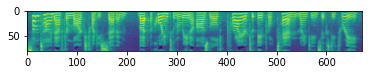

In [8]:
example_datapoint = train_dataset[666]
print(f"Datasets yield: {', '.join(example_datapoint.keys())}")
plt.imshow(example_datapoint['spectrogram']);

To "play" spectrograms, including those that you will generate, we will use another deep learning algorithm called [WaveGlow](https://arxiv.org/abs/1811.00002). It converts mel spectrograms to audio.

Fortunately, there *is* code for it on GitHub, so you won't have to reimplement it 🙂 Still, if you haven't done so, I encourage you to watch a short [video](https://www.youtube.com/watch?v=CqFIVCD1WWo) about a famous paper that it's based on.

In [0]:
vocoder = lj_speech.Vocoder()

In [10]:
print(example_datapoint['text'])

example_spectrogram = torch.from_numpy(example_datapoint['spectrogram'])
audio = vocoder(example_spectrogram)
lj_speech.play_audio(audio)

sometime after march twenty-seven, but according to marina oswald, prior to april ten, nineteen sixty-three,


Finally, we have phonemes as inputs, but we'd like to synthesize arbitrary text. For that, there is a function `lj_speech.text_to_phonemes(text)`.

## Method

Reimplement the baseline method defined by the diagram below. It's derived from a simplified version of the [DurIAN paper](https://arxiv.org/abs/1909.01700).

Just in case, here are some of the most notable differences from DurIAN:
* Prosodic boundary markers aren't used (we don't have them labeled), and thus there's no 'skip states' exclusion of prosodic boundaries' hidden states.
* Style codes aren't used too (same).
* Simpler network architectures.
* No pre-net in decoder.
* No attention used in decoder.
* Decoder's recurrent cell outputs single spectrogram frame at a time.
* Decoder's recurrent cell isn't conditioned on its own outputs (isn't "autogressive").

![pipeline](https://user-images.githubusercontent.com/9570420/81863803-6f0ba300-9574-11ea-9f02-481c2bba81f0.png)

This picture is the simplified Figure 1 from the paper. **Use the paper as a reference**. If something is unclear from the diagram — and, in fact, some things are intentionally omitted — search answers in the paper (but remain aware of the differences/simplifications in the above diagram) and other papers that the authors cite. There will even be details that aren't even mentioned anywhere in the paper, so you'll have to guess by your intuition. For instance, DurIAN paper doesn't explain batch size and sampling strategy, and even if it did, it would be irrelevant since we use different data. Finally, search the Web and read others' code; however, if you copy-paste code, **cite it**.

Tips:
* Only compute loss on the 'original' parts of the spectrograms (don't include padding)!
* When using recurrent nets, [clip gradients' norm](https://pytorch.org/docs/stable/nn.html#torch.nn.utils.clip_grad_norm_).
* Since you will use recurrent nets, and the sequences in a batch will be of different lengths, you may find [sequence packing utility](https://stackoverflow.com/questions/51030782/why-do-we-pack-the-sequences-in-pytorch) useful.
* Remember that you can send images and audio into TensorBoard, too.

**Train this baseline so that the words are well-recognizable, and try to get rid of the "metallic", "tin sounding" voice.**

**Aim for something like this:**

In [0]:
lj_speech.play_audio(scipy.io.wavfile.read(AUX_DATA_ROOT / 'ok.wav')[1])

**On the other hand, here is an example of insufficient quality:**

In [0]:
lj_speech.play_audio(scipy.io.wavfile.read(AUX_DATA_ROOT / 'bad.wav')[1])

## Improving the Method

When you have the baseline working, seek the ways to improve quality and to decrease loss. Look into the paper and the relevant/neighbouring literature. Also, follow your intuition, e.g. for changing model complexity or regularization. For example, you can (but aren't obliged to) try borrowing more tricks from DurIAN; a couple of examples for inspiration:

* Make decoder recurrent cell autoregressive as in the paper: use its output as its input at the next preiction step.
* Add pre-net to decoder.
* Add attention to decoder.
* Use more complex sub-network architectures (e.g. use CBHG).
* Employ tricks from Tacotron {[1](https://arxiv.org/abs/1703.10135),[2](https://arxiv.org/abs/1712.05884)} — papers that DurIAN is based upon, e.g. [zoneout](https://arxiv.org/abs/1606.01305) in RNNs.

Write a report on your journey to better loss. Explain if you managed to perceptibly improve the quality and lower the loss, what you tried and why, what worked and what didn't. Include TensorBoard loss plots.

## Deliverables

1. This file, fully functional, reproducing all the reported results on "Run all". Out-of-the box `TextToSpeechSynthesizer` class (see interface below) and demo code of running it on arbitrary text.
2. Report on improving the baseline at the end of this file.
3. Two "checkpoint files" with weights for both of your models (baseline and the improved model).

## Grading

* **[7 points]** Baseline.
* **[3 points]** Improving of the baseline.

In [0]:
import torch.nn as nn
from torch.utils import data
from torch.utils.tensorboard import SummaryWriter
import os
from datetime import datetime
BATCH_SIZE = 100
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [0]:
class Encoder(nn.Module):
    def __init__(self, num_chars):
        super().__init__()
        self.embedding = nn.Embedding(num_chars, 256, padding_idx=0)
        self.conv_resid = nn.Sequential(
                                        ConvResidualBlock1D(256, 256, 0.5),
                                        ConvResidualBlock1D(256, 256, 0.5),
                                        ConvResidualBlock1D(256, 512, 0.5),
                                        ConvResidualBlock1D(512, 512, 0.5),
                                        ConvResidualBlock1D(512, 512, 0.5)
                                        )
        self.bi_GRU = self.rnn = nn.GRU(512, 256, batch_first=True, bidirectional=True )

    def forward(self, x, length):
        x = self.embedding(x)
        x = x.permute(0,2,1)
        x = self.conv_resid(x)
        x = x.permute(0,2,1)
        x = nn.utils.rnn.pack_padded_sequence(x, length, batch_first=True, enforce_sorted=False)
        x, _ = self.bi_GRU(x)
        x, _ = nn.utils.rnn.pad_packed_sequence(x, batch_first=True, padding_value=0)
        return x

class ConvResidualBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, p):
        super().__init__()
        self.sequential = nn.Sequential(nn.Conv1d(in_channels, out_channels, 5, padding = 2),
        nn.ReLU(),
        nn.BatchNorm1d(out_channels),
        nn.Dropout(p)
        )
        self.conv = nn.Conv1d(in_channels, out_channels, 1, padding = 0)

    def forward(self, x):
        return torch.add(self.sequential(x), self.conv(x))

class AlignmentModel(nn.Module):
    
    def __init__(self):
        super(AlignmentModel, self).__init__()
        
    def forward(self, x, durations):
        device = x.device
        hidden_size = x.size()[2]  
        batch_size = x.size()[0]   
        durations = durations.reshape(-1)
        x = torch.cat((x, torch.zeros((batch_size, 1, hidden_size), device=device)), dim=1).view(-1, hidden_size)
        x = x.repeat_interleave(durations, dim=0)      
        durations = durations[torch.nonzero(durations, as_tuple=True)]
        frame_position = torch.cat([torch.linspace(0, 1, i) for i in durations], dim=0).unsqueeze(1).to(device)
        x = torch.cat((x, frame_position), dim=1)
        return x.reshape(batch_size, -1, hidden_size + 1)

class Decoder(nn.Module):
    def __init__(self, in_size):
        super().__init__()
        self.gru = self.rnn = nn.GRU(in_size, 256, batch_first=True, num_layers=2 )
        self.post_net = nn.Sequential(
                                        ConvResidualBlock1D(256, 256, 0.0),
                                        ConvResidualBlock1D(256, 256, 0.0),
                                        ConvResidualBlock1D(256, 256, 0.0),
                                        ConvResidualBlock1D(256, 256, 0.0),
                                        ConvResidualBlock1D(256, 256, 0.0)
                                        )
        self.conv1 = nn.Conv1d(256, lj_speech.MEL_SCALE_BINS, kernel_size=1)
        self.conv2 = nn.Conv1d(256, lj_speech.MEL_SCALE_BINS, kernel_size=1)
    def forward(self, x, length):
        x = nn.utils.rnn.pack_padded_sequence(x, length, batch_first=True, enforce_sorted=False)
        x, _ = self.gru(x)
        x, _ = nn.utils.rnn.pad_packed_sequence(x, batch_first=True, padding_value=0)
        x_1 = x.permute(0,2,1)
        x_1 = self.conv1(x_1)
        x_1 = x_1.permute(0,2,1)
        x_2 = x.permute(0,2,1)
        x_2 = self.conv2(self.post_net(x_2))
        x_2 = x_2.permute(0,2,1)
        return x_1, x_2

class DurIAN(nn.Module):
    def __init__(self, num_chars):
        super().__init__()
        self.encoder = Encoder(num_chars)
        self.alignment = AlignmentModel()
        self.decoder = Decoder(513)
    def forward(self, phonemes, length, durations, stack):
        hidden_repres = self.encoder(phonemes, length)
        phonemes_aligned = self.alignment(hidden_repres, durations)
        pred_spectr, post_pred_spectr = self.decoder(phonemes_aligned, stack)
        return pred_spectr, post_pred_spectr

class CustomL1(nn.Module): 
    def __init__(self):
        super(CustomL1, self).__init__()   
    def forward(self, y_pred, y_true, length):
        l1 = nn.L1Loss()
        y_true = y_true.data.to(torch.float)
        y_pred = nn.utils.rnn.pack_padded_sequence(y_pred, length, batch_first=True, enforce_sorted=False).data
        loss = l1(y_pred, y_true)
        return loss

In [0]:
phonemes = lj_speech.POSSIBLE_PHONEME_CODES
length = len(phonemes)
vocab_to_index = dict(zip(sorted(list(phonemes)), range(length)))

In [0]:
def custom_collate(batch):
    phon = []
    for dictionary in batch:
      indexes = torch.LongTensor([vocab_to_index[phoneme] for phoneme in dictionary['phonemes_code']])
      phon += [indexes]
    phon = nn.utils.rnn.pack_sequence(phon, enforce_sorted=False)
    phon, lng = nn.utils.rnn.pad_packed_sequence(phon, batch_first=True, padding_value=0)  
    stack_dur = [torch.tensor(sum(dictionary['phonemes_duration'])) for dictionary in batch]
    stack_dur = torch.stack(stack_dur, dim=0)
    spectr = [torch.from_numpy(dictionary['spectrogram'])[:,:stack_dur[i]].permute(1,0) for i, dictionary in enumerate(batch)]
    dur_max = max(spectr, key=len).size(0)
    spectr = nn.utils.rnn.pack_sequence(spectr, enforce_sorted=False)  
    dur = [torch.tensor(dictionary['phonemes_duration'] + [dur_max - stack_dur[i]]) for i, dictionary in enumerate(batch)]
    dur  = nn.utils.rnn.pad_sequence(dur, batch_first=True, padding_value=0)
    return (phon, dur, spectr, lng, stack_dur)

In [0]:
train_loader = data.DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE, collate_fn=custom_collate)
val_loader   = data.DataLoader(val_dataset, shuffle=False, batch_size=BATCH_SIZE, collate_fn=custom_collate)

In [0]:
def run_epoch(model, optimizer, train_loader, device, scheduler=None, phase='train', epoch=0, writer=None):
    is_train = (phase == 'train')
    if is_train:
        model.train()
    else:
        model.eval()
    
    epoch_loss = 0
    criterion = CustomL1()
    
    with torch.set_grad_enabled(is_train):
        for i, batch in enumerate(train_loader):
            global_i = len(train_loader) * epoch + i   
            phonemes, durations, spectrograms, length, stack_dur = batch
            phonemes, durations, spectrograms, length, stack_dur = phonemes.to(device), durations.to(device), spectrograms.to(device), \
            length.to(device), stack_dur.to(device)           
            pred, res = model(phonemes, length, durations, stack_dur)
            loss1 = criterion(pred, spectrograms, stack_dur)
            loss2 = criterion(pred + res, spectrograms, stack_dur)
            loss  = loss1 + loss2
            
            if is_train:
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.5)
                optimizer.step()

            if writer is not None and is_train:
                writer.add_scalar(f"loss/{phase}", loss.item(), global_i)
            
            epoch_loss += loss.item()
    
    epoch_loss = epoch_loss / len(train_loader)
    if writer is not None and is_train:
        writer.add_scalar(f"loss_epoch/{phase}", epoch_loss, epoch)
        
    return epoch_loss

In [0]:
def setup_experiment(title, logdir="./tb"):
    experiment_name = "{}@{}".format(title, datetime.now().strftime("%d.%m.%Y-%H:%M:%S"))
    writer = SummaryWriter(log_dir=os.path.join(logdir, experiment_name))
    best_model_path = f"{title}.best.pth"
    return writer, experiment_name, best_model_path

In [0]:
model = DurIAN(len(lj_speech.POSSIBLE_PHONEME_CODES)+1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=8e-4)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20,30,40], gamma=0.5)

In [0]:
DO_TRAIN = False

In [99]:
if DO_TRAIN == True:
  writer, experiment_name, best_model_path = setup_experiment("DureIAN", logdir="./tb")
  print(f"Experiment name: {experiment_name}")

  n_epochs = 15

  best_val_loss = float('+inf')
  for epoch in range(n_epochs):
      train_loss = run_epoch(model, optimizer, train_loader, device, scheduler=scheduler, phase='train', epoch=epoch, writer=writer)
      val_loss   = run_epoch(model, None, val_loader, device, scheduler=None, phase='val', epoch=epoch, writer=writer)
      
      if val_loss < best_val_loss:
          best_val_loss = val_loss
          torch.save(model.state_dict(), best_model_path)
      
      print(f'Epoch: {epoch+1:02}')
      print(f'\tTrain Loss: {train_loss:.3f}')
      print(f'\t Val. Loss: {val_loss:.3f}') 

Experiment name: DureIAN@24.05.2020-18:01:39
Epoch: 01
	Train Loss: 3.090
	 Val. Loss: 2.237
Epoch: 02
	Train Loss: 1.940
	 Val. Loss: 1.841
Epoch: 03
	Train Loss: 1.724
	 Val. Loss: 1.658
Epoch: 04
	Train Loss: 1.647
	 Val. Loss: 1.611
Epoch: 05
	Train Loss: 1.607
	 Val. Loss: 1.588
Epoch: 06
	Train Loss: 1.581
	 Val. Loss: 1.551
Epoch: 07
	Train Loss: 1.564
	 Val. Loss: 1.541
Epoch: 08
	Train Loss: 1.551
	 Val. Loss: 1.526
Epoch: 09
	Train Loss: 1.539
	 Val. Loss: 1.523
Epoch: 10
	Train Loss: 1.530
	 Val. Loss: 1.518
Epoch: 11
	Train Loss: 1.520
	 Val. Loss: 1.515
Epoch: 12
	Train Loss: 1.514
	 Val. Loss: 1.504
Epoch: 13
	Train Loss: 1.508
	 Val. Loss: 1.499
Epoch: 14
	Train Loss: 1.501
	 Val. Loss: 1.489
Epoch: 15
	Train Loss: 1.497
	 Val. Loss: 1.484


In [0]:
val_sample = data.DataLoader(val_dataset, shuffle=False, batch_size=1, collate_fn=custom_collate)
for i in val_sample:
  val_sample = i
  break

In [0]:
model_main = DurIAN(55)
model_main.load_state_dict(torch.load("./DureIAN.best.pth", map_location=torch.device(device)))
model_main.eval() 

pred, res = model_main(val_sample[0], val_sample[3], val_sample[1], val_sample[4])


In [128]:
audio = vocoder(pred.reshape(1, 80, -1))
lj_speech.play_audio(audio)

Most probably I just did not train it enough amount of epochs.

In [110]:
%load_ext tensorboard
logs_base_dir = "./tb"
os.makedirs(logs_base_dir, exist_ok=True)
%tensorboard --logdir {logs_base_dir}

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


<IPython.core.display.Javascript object>

/usr/lib/python3.6/subprocess.py:786: ResourceWarning: subprocess 4831 is still running
  ResourceWarning, source=self)


![Screenshot of loss](https://drive.google.com/open?id=1zn8k9vnbK5L7-Z9m6Bov3Bz2QJafBdlR)

In [0]:
class TextToSpeechSynthesizer:
    """
    When done, please fill this class. It should work out-of-the-box, i.e.
    have a simple interface, automatically load model weights,
    process text to speech at one command without errors etc.
    """
    def __init__(self, checkpoint_path, <any-other-arguments>):
        """
        Initialize anything you may need. For example, load model weights from disk.
        """
        pass
    
    def synthesize_from_text(self, text):
        """
        Synthesize text into voice.

        text:
            str
        
        return:
        audio:
            torch.Tensor or numpy.ndarray, shape == (1, t)
        """
        phonemes = lj_speech.text_to_phonemes(text)
        return self.synthesize_from_phonemes(phonemes)

    def synthesize_from_phonemes(self, phonemes, durations=None):
        """
        Synthesize phonemes into voice.

        phonemes:
            list of str
            ARPAbet phoneme codes.
        durations:
            list of int, optional
            Duration in spectrogram frames for each phoneme.
            If given, will be used for hard alignment in the model (like during
            training); otherwise, durations will be predicted by the duration
            model.
        
        return:
        audio:
            torch.Tensor or numpy.ndarray, shape == (1, t)
        """
        # Your code here

        spectrogram = ...
        return vocoder(spectrogram)

In [0]:
# Example:
synthesizer = TextToSpeechSynthesizer("./DurIAN.best.pth", )

In [0]:
phonemes = "DH IH1 S pau pau pau IH1 Z pau pau pau S P AH1 R T AH1 AH1 AH1 pau".split()
lj_speech.play_audio(
    synthesizer.synthesize_from_phonemes(phonemes))

In [0]:
text = "Pack my box with five dozen liquor jugs."
# text = "The five boxing wizards jump quickly."
# text = "The quick brown fox jumps over the lazy dog."
# text = "How about some school tech."
# text = "Last homework. We are in a deep trouble. No sleep tonight."

lj_speech.play_audio(
    synthesizer.synthesize_from_text(text))